In [431]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.notebook import tqdm 
import h5py
#%matplotlib widget

In [135]:
datapath ="./Dlotko_dane/text_files/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
signal_list = []
for filename in sorted(filelist):
    signal_list.append(np.loadtxt(datapath+filename))

['good_cond_Gauss.txt', 'good_cond_Gauss_ch_b.txt', 'sig1a.txt', 'sig1b.txt', 'sig2a.txt', 'sig2b.txt', 'sig3a.txt', 'sig3b.txt']


In [462]:
minlengeth = min([len(s) for s in signal_list])
for i in range(len(signal_list)):
    signal_list[i] = signal_list[i][:minlengeth]

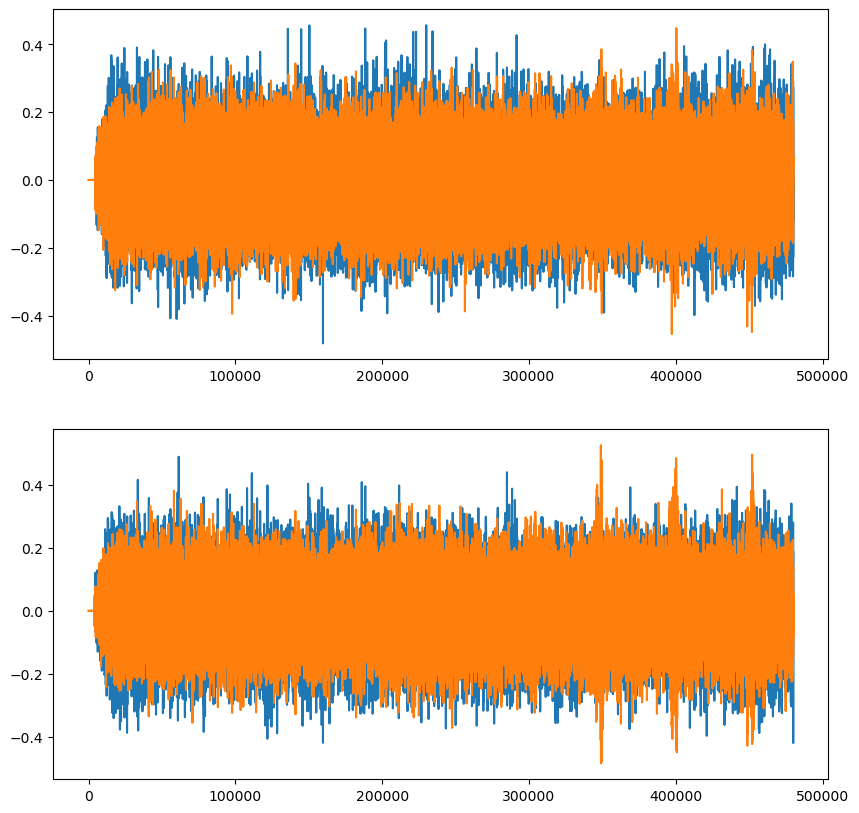

In [463]:
f,ax = plt.subplots(2,1, figsize =(10,10))
ax[0].plot(signal_list[0])
ax[0].plot(signal_list[2])
ax[1].plot(signal_list[1])
ax[1].plot(signal_list[3])
plt.show()

In [464]:
def compute_diagram(data, dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 100):
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>250):
        skip = max(len(point_clouds)//250,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0] 
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    #print(len(pc))

    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    return pd

In [480]:
n_samples = 30
norms = np.zeros((len(signal_list),n_samples))
start = 3
end = 7.3
grid = np.linspace(start,end,10000)
bc = BettiCurve(predefined_grid=grid)
betti_curves = np.zeros((len(signal_list),n_samples,10000))




for j in tqdm(range(0,len(signal_list))):
    scaling_factor =(j+2)*0.5    
    dim = 34#int(90*(1/(scaling_factor)))
    delay = 463#int(120*(1/(scaling_factor)**2))#int(90*scaling_factor)
    
    #print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))
    
    skip =1
    samples = np.array_split(signal_list[j],n_samples)
        
    for k in range(0,len(samples)):
        pd = compute_diagram(samples[k], dim, delay, skip, point_cloud_size = 100)
        if j == 0 or j == 1:
            print(pd)
        #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
        curve = np.array(bc.fit_transform([pd])[0])
        betti_curves[j,k] = curve
        #norm = compute_norms_from_ts(samples[k], dim, delay, skip)
        norm = wasserstein_distance(pd,[], order=1, internal_p = 1)

        norms[j,k] = norm

  0%|          | 0/8 [00:00<?, ?it/s]

[[5.60530277 5.62474151]
 [5.65849968 5.71963513]
 [5.95761283 6.04580315]
 [6.14857624 6.15474999]
 [6.16087158 6.16764298]
 [6.28407998 6.38327563]
 [6.34978686 6.42772005]
 [6.5454004  6.55636907]
 [6.70688448 6.74350869]]
[[6.20361483 6.22353021]
 [6.360129   6.43092366]
 [6.20664339 6.45390112]
 [6.44327879 6.45476756]
 [6.27421364 6.46768117]
 [6.90404943 6.9045657 ]]
[[6.15912885 6.19347055]]
[[6.50003248 6.50065158]
 [6.62461595 6.63612485]
 [6.79585309 6.79973573]
 [6.8889518  6.89881589]
 [6.91386598 6.92615258]
 [7.03214449 7.04905827]
 [7.08004999 7.08256614]
 [7.23833751 7.24130158]]
[[6.33388992 6.34262887]
 [6.82224485 6.83167355]
 [7.12821305 7.13406847]]
[[6.23037795 6.26288697]
 [6.20789298 6.29407372]
 [6.17381317 6.31822906]
 [6.25119129 6.34958008]
 [6.4054637  6.41545199]
 [6.40718826 6.44074137]
 [6.47146168 6.48827629]
 [6.40661378 6.48960105]
 [6.49384892 6.49621578]
 [6.52256582 6.55952914]
 [6.55340611 6.57473401]
 [6.63297413 6.67333889]
 [6.47042578 6.73146

[[6.07788182 6.10500308]
 [6.26169524 6.33821197]
 [6.88760012 6.91227258]
 [6.90844085 6.92672828]
 [6.91958518 6.93395813]
 [7.15605091 7.20730546]
 [7.33293683 7.33964804]]
[[5.70808806 5.7101494 ]
 [6.37695603 6.40598412]]
[[6.17180264 6.19887822]
 [6.2055319  6.21264672]
 [6.1823092  6.22039739]
 [6.01701074 6.23908691]
 [6.18398045 6.31267229]
 [6.40961836 6.42206584]
 [6.40089333 6.43189642]
 [6.41874988 6.47977603]
 [6.53179457 6.53464004]
 [6.54116158 6.55524042]
 [6.57550504 6.57611807]
 [6.630425   6.65635738]
 [6.73598055 6.80794869]
 [6.82531068 6.82911768]]
[[5.94698183 5.97780033]
 [6.23874634 6.26436326]]
[[5.88517378 5.88754267]
 [6.01386502 6.03696265]
 [6.04374153 6.04981168]
 [6.08816833 6.18570189]
 [6.19279348 6.21949333]
 [6.31777988 6.32391982]
 [6.24236824 6.37430991]
 [6.40948179 6.45608362]
 [6.43208517 6.45764673]]
[[6.19848095 6.23252371]
 [6.50611762 6.51940332]
 [6.4921046  6.52925442]
 [6.69010417 6.7121216 ]
 [6.95948765 6.97175106]
 [7.03835197 7.05787

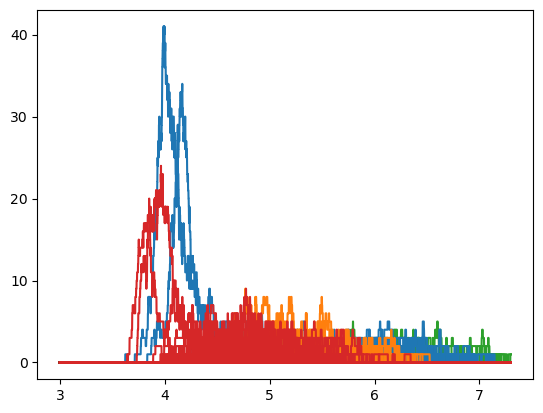

In [481]:
f,ax = plt.subplots()
for j in [0,1,2,3,4,5,6,7]:
    for k in range(0,len(samples)):
        ax.plot(grid, betti_curves[j][k], color=colors[j//2])
plt.show()

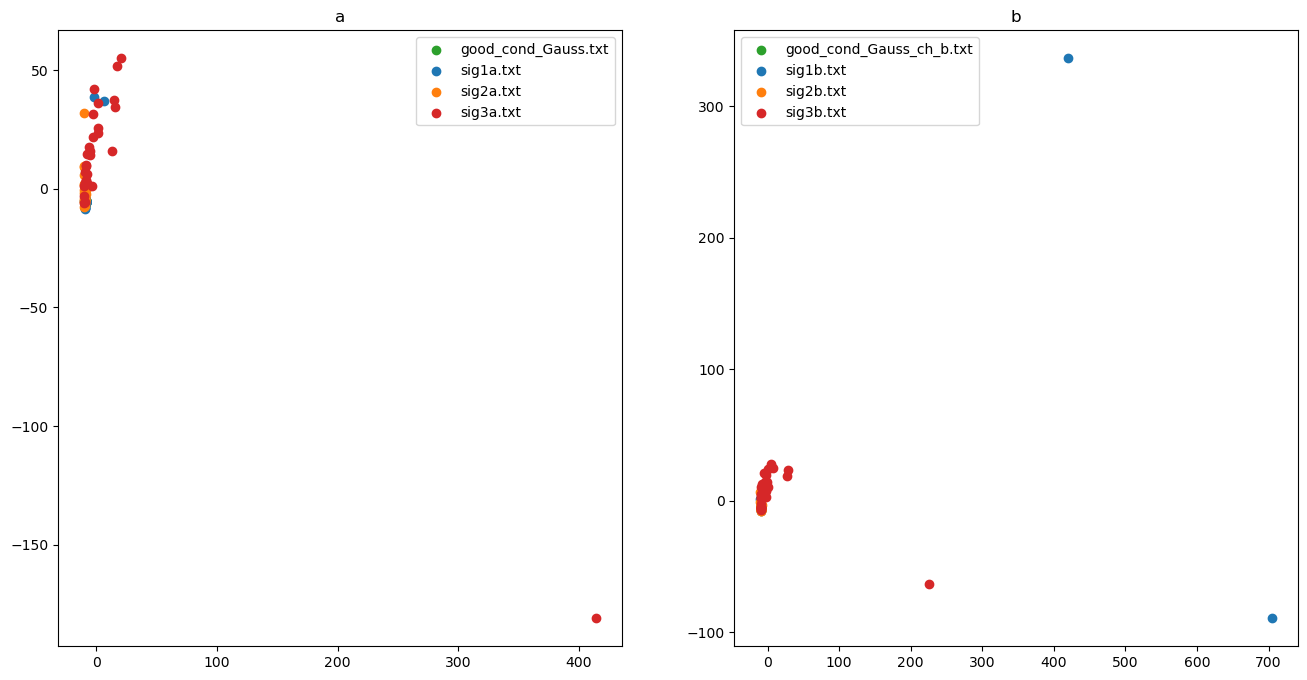

explained variance: [0.51029669 0.10493169 0.07206105]
silhouette score -0.09789610817870426


In [482]:
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,k] for j in range(0,len(signal_list)) for k in range(0,n_samples)])
labels = np.repeat([1,2,3,4], 2*n_samples)
fig,ax = plt.subplots(1,2,figsize=(16,8))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:green", "tab:blue", "tab:orange", "tab:red"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in [0,1,2,3]:
    emb_a = pca.transform(betti_curves[2*i,:])
    ax[0].scatter(emb_a[:,0],emb_a[:,1], marker = "o", c=colors[i], label=filenames[2*i])    
    ax[0].set_title("a")
    ax[0].legend()
    
    emb_b = pca.transform(betti_curves[2*i+1,:])
    ax[1].scatter(emb_b[:,0],emb_b[:,1], marker = "o", c=colors[i], label=filenames[2*i+1])
    ax[1].set_title("b")
    ax[1].legend()


plt.show()
print("explained variance:", pca.explained_variance_ratio_)
print("silhouette score",silhouette_score(betti_curves.reshape(8*n_samples, len(grid)), labels))

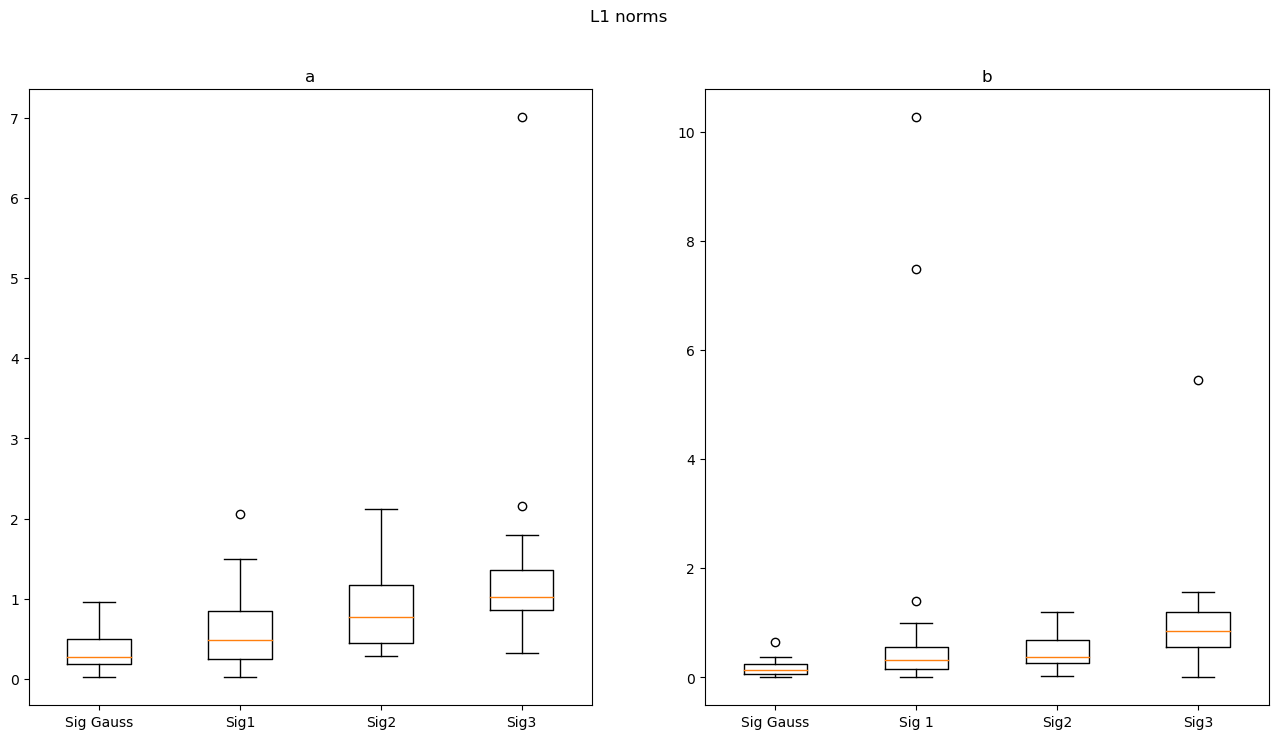

In [483]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].boxplot([norms[0,:],norms[2,:],norms[4,:],norms[6,:]])
ax[0].set_title("a")
ax[0].set_xticklabels(["Sig Gauss", "Sig1", "Sig2", "Sig3"])
 
ax[1].boxplot([norms[1,:],norms[3,:],norms[5,:],norms[7,:]])
ax[1].set_title("b")
ax[1].set_xticklabels(["Sig Gauss", "Sig 1", "Sig2", "Sig3"])
          
fig.suptitle("L1 norms")
plt.show()

In [469]:
#grid search

n_samples = 30
norms = np.zeros((len(signal_list),n_samples))
start = 2.5
end = 8
grid = np.linspace(start,end,10000)
bc = BettiCurve(predefined_grid=grid)
labels = np.repeat([1,2,3,4], 2*n_samples)

def compute_curve_scores(dim, delay):
    if dim*delay > 15000:
        return 0
    betti_curves = np.zeros((len(signal_list),n_samples,10000))
    for j in tqdm(range(0,len(signal_list))):


        #print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))

        skip =1
        samples = np.array_split(signal_list[j],n_samples)

        for k in range(0,len(samples)):
            #print(i,j,k)
            dgm = compute_diagram(samples[k], dim, delay, skip, point_cloud_size = 100)
            #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
            curve = np.array(bc.fit_transform([dgm])[0])
            betti_curves[j,k] = curve
            #norm = compute_norms_from_ts(samples[k], dim, delay, skip)

    return(silhouette_score(betti_curves.reshape(8*n_samples, len(grid)), labels))

def search_hyperbola(p):
    vals = np.geomspace(np.sqrt(p),np.sqrt(p)*p,int(p-112), dtype=int)
    labels = np.repeat([1,2,3,4], 2*n_samples)    
    scores = Parallel(n_jobs=-1)(delayed(compute_curve_scores)(vals[i], vals[-(i+1)]) for i in range(0,len(vals)))
                
    return np.array(scores)
    

#product = np.linspace(115,124,10)
dels = np.linspace(5,13,9)
dims = np.linspace(1096,2629,22)
#scores = Parallel(n_jobs=-1)(delayed(search_hyperbola)(p) for p in product)
scores = Parallel(n_jobs=-1)(delayed(compute_curve_scores)(int(i),int(j)) for i in dims for j in dels)

  0%|          | 0/8 [00:00<?, ?it/s]


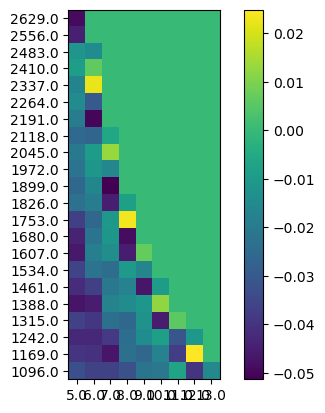

In [470]:
np.array(scores).reshape((len(dims),len(dels)))
f,ax=plt.subplots()

img = ax.imshow(np.array(scores).reshape((len(dims),len(dels))), origin="lower")
plt.colorbar(img)

ax.set_xticks(range(len(dels)))
ax.set_yticks(range(len(dims)))
ax.set_xticklabels(dels)
ax.set_yticklabels(dims)

plt.show()

In [434]:
indices = set()
for p in product:
    indices = indices | set(np.geomspace(1,p*p,int(p/10), dtype=int))
    
indices = np.array(list(indices))
indices.sort()

   

In [435]:
df = pd.DataFrame(0, index=indices, columns=indices)

for i in range(len(scores)):
    p=product[i]
    vals = np.geomspace(1,p*p,int(p/10), dtype=int)
    for j in range(len(scores[i])):
        print(vals[j],vals[-(j+1)], scores[i][j])
        df.at[vals[j],vals[-(j+1)]] = scores[i][j]
        

df

1 13225 -0.03074905131972589
2 5119 0.2715778392542726
6 1982 0.1049371314099182
1 13456 -0.05049219354869884
2 5200 0.29223669718235407
6 2009 0.29157590194750704
17 776 0.1174193066910577
1 13689 -0.03625315978905968
2 5281 0.19939867310882506
6 2037 0.39164178685866813
17 786 0.24721157693345067
45 303 0.1384183802328538
1 13924 -0.038990229357174604
2 5362 0.298341936539427
6 2065 0.4581462448062785
17 795 0.3252671805407353
45 306 0.18009296221946422
118 118 0.1485939592753874
1 14161 -0.023467618528379856
2 5444 0.2638602289966953
6 2093 0.46624782732581094
17 804 0.3843834794923879
45 309 0.2697426216231916
118 118 0.19042361761226737
309 45 0.15090639356016425
1 14400 -0.032677532521212055
2 6030 0.23218601089728325
5 2525 0.4650721784696808
13 1057 0.4422878770847041
32 442 0.3538845739717617
77 185 0.24300201122066264
185 77 0.16609644087830602
442 32 0.13354643020482715
1 14641 -0.00979813654587396
2 6121 0.3372237276674088
5 2559 0.4373458307467469
13 1070 0.469830721077990

,1,2,5,6,13,17,32,33,44,45,...,13225,13456,13689,13924,14161,14400,14641,14884,15129,15376
1,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,-0.030749,-0.050492,-0.036253,-0.03899,-0.023468,-0.032678,-0.009798,0.083905,0.130484,0.171428
2,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14400,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14641,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14884,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15129,0.000000,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


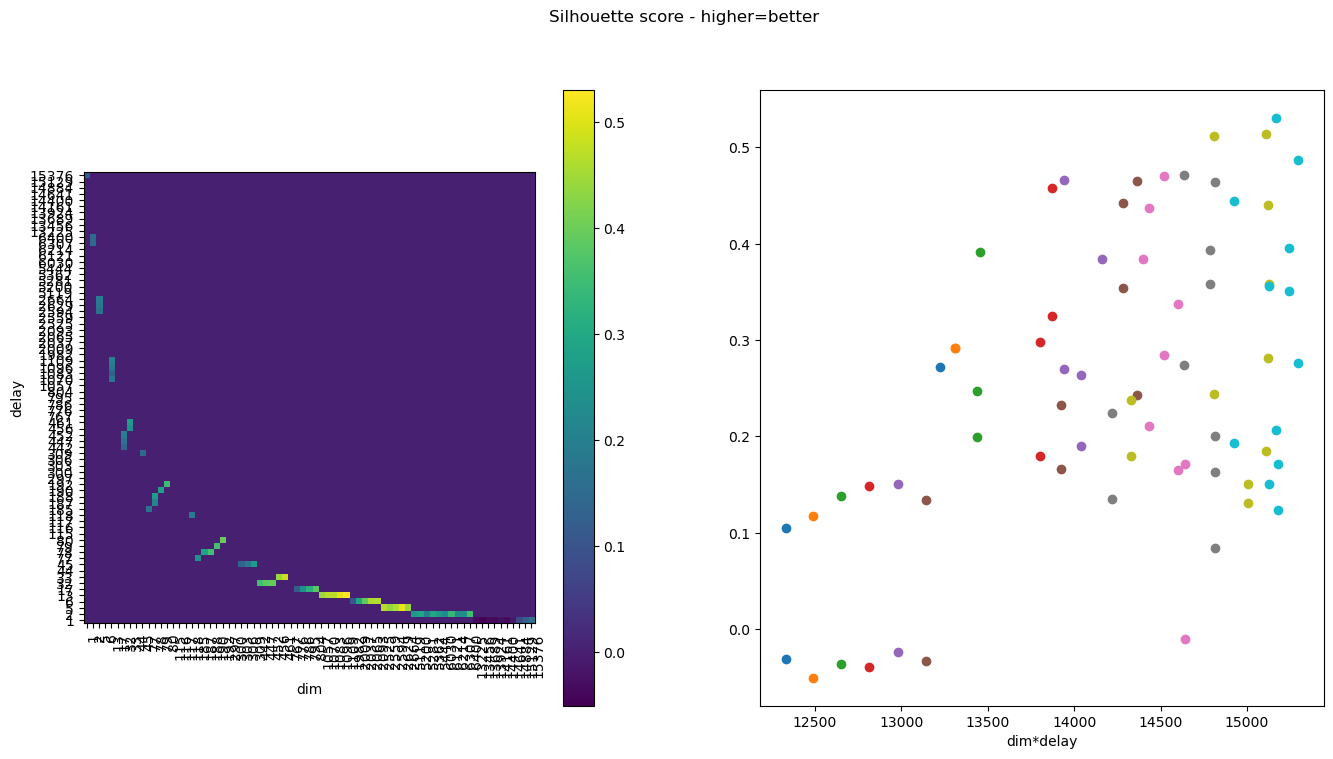

In [437]:
f,ax = plt.subplots(1,2,figsize=(16,8))
im = ax[0].imshow(df, origin="lower")
plt.colorbar(im)
ax[0].set_xticks(range(len(indices)))
ax[0].set_yticks(range(len(indices)))
ax[0].set_xticklabels(indices)
ax[0].set_yticklabels(indices)
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
ax[0].set_xlabel("dim")
ax[0].set_ylabel("delay")

for i in range(len(scores)):
    p = product[i]
    vals = np.geomspace(np.sqrt(p),np.sqrt(p)*p,int(p-112), dtype=int)
    ax[1].scatter(vals*np.flip(vals), scores[i])
ax[1].set_xlabel("dim*delay")

plt.suptitle("Silhouette score - higher=better")
plt.show()